Задание 1:

Выберите 2 любые компании, которые имеют листинг на фондовом рынке США. Выгрузите дневные данные начиная с 2017 по настоящее время по этим 2-м компаниям и сформируйте датасет для временного ряда (итого у вас 2 датасета). 
Цель задания - проведите исследование и статистический анализ временного ряда по сформированным датасетам, посчитайте все основные статистики для временного ряда, превратите ваши временные ряды в стационарные и сформируйте отчет с выводами и визуализациями в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

Итоговая оценка за правильно выполненное задание: 3 балла.

Задание 2:

Выберите 1 из 2-ух временных рядов из задания 1 и сделайте прогноз на ближайший месяц-квартал-полугодие  и год. Модель выбирать исходя из ваших предположений и умозаключений. Необходимо обосновать почему была выбрана та или иная модель и на каких основаниях, в чем она лучше и почему она подходит. Оценить качество прогноза согласно выбранной метрике, проверить качество на отложенной выборке путем применения TimeSeriesSplit. Сформировать отчет с выводами и визуализациями в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

Итоговая оценка за правильно выполненное задание: 3 балла.

Задание 3:
У вас есть архив с данными по производству электроэнергии ветряными мельницами в Германии. Вам необходимо исследовать временной ряд, описать основные статистики для временного ряда, сделать вывод по временному ряду и сформировать исследовательский отчет подкрепленный соответствующими выводами. 

Необходимо выбрать модель для прогноза временного ряда, объяснить почему именно была выбрана данная модель, объяснить на каком основании. Сделайте прогноз по производству электроэнергии на 1 год вперед, измерить метрику качества. Оформить исследование в jupyter notebook’e.

Без отчета с подкрепленными выводами задание считается проваленным (то есть ноутбук с кодом и картинками мне не присылать).

Итоговая оценка за правильное и качественно выполненное задание 4 балла. 

In [391]:
import warnings
warnings.filterwarnings("ignore")
!pip install yfinance statsmodels matplotlib pandas pmdarima arch catboost --quiet
!pip install pmdarima statsmodels prophet torch torchvision scikit-learn matplotlib pandas --quiet

In [246]:
#Задание 1:
#выберу Пару акций Microsoft и Apple (MSFT AAPL)
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [247]:
# Задаём тикеры и период
tickers = ["AAPL", "MSFT"]
start_date = "2017-01-01"
end_date   = pd.to_datetime("today").strftime("%Y-%m-%d")

# Загружаем данные
data = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Разделяем на два отдельных ряда
aapl = data["AAPL"].dropna()
msft = data["MSFT"].dropna()

[*********************100%***********************]  2 of 2 completed


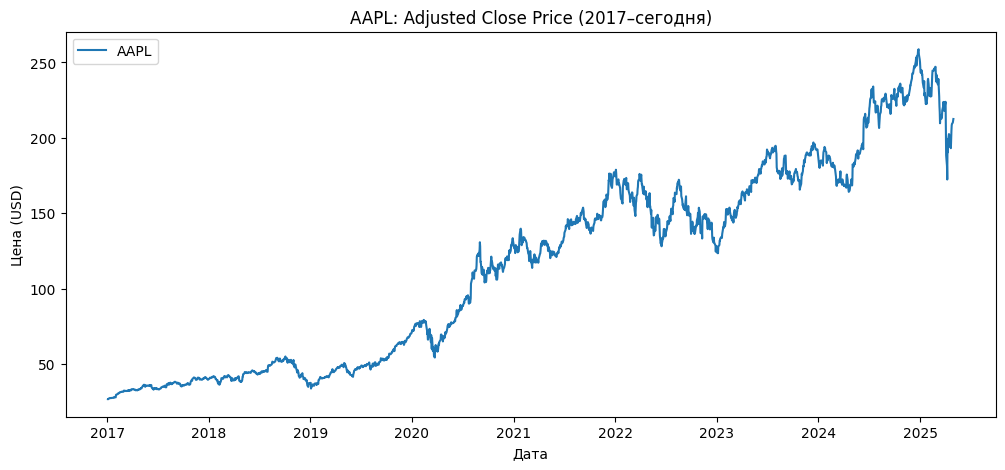

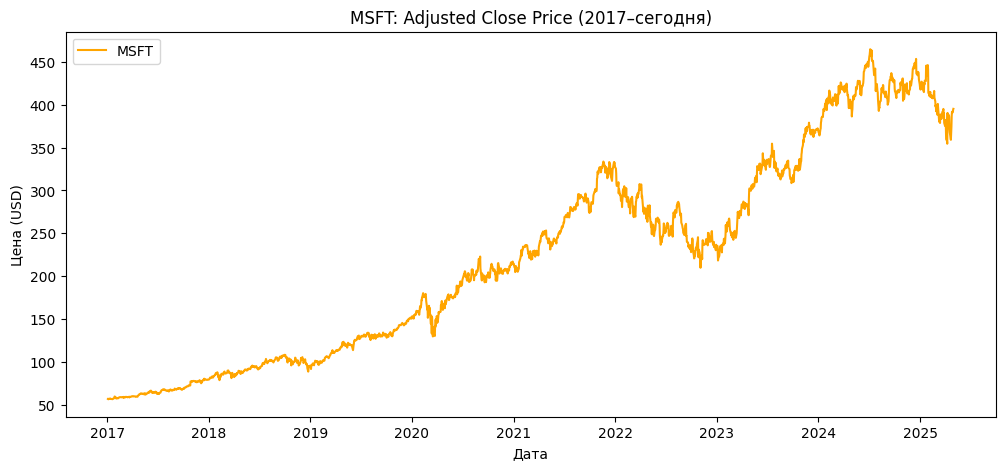

In [248]:
#Исследовательский анализ (EDA)

# График AAPL
plt.figure(figsize=(12,5))             
plt.plot(aapl.index, aapl, label="AAPL")
plt.title("AAPL: Adjusted Close Price (2017–сегодня)")
plt.xlabel("Дата")
plt.ylabel("Цена (USD)")
plt.legend()
plt.show()                             

# График MSFT
plt.figure(figsize=(12,5))             
plt.plot(msft.index, msft, label="MSFT", color='orange')
plt.title("MSFT: Adjusted Close Price (2017–сегодня)")
plt.xlabel("Дата")
plt.ylabel("Цена (USD)")
plt.legend()
plt.show()                             


In [249]:
#Основные статистики
def summary_stats(ts):
    return {
        "Mean": ts.mean(),
        "StdDev": ts.std(),
        "Min": ts.min(),
        "Max": ts.max(),
        "Skewness": ts.skew(),
        "Kurtosis": ts.kurtosis()
    }

stats_aapl = summary_stats(aapl.pct_change().dropna())
stats_msft = summary_stats(msft.pct_change().dropna())

pd.DataFrame([stats_aapl, stats_msft], index=["AAPL Returns", "MSFT Returns"])

,Mean,StdDev,Min,Max,Skewness,Kurtosis
AAPL Returns,0.001169,0.018965,-0.128647,0.153289,0.139974,6.882144
MSFT Returns,0.001082,0.017464,-0.147390,0.142169,0.062849,7.507169


In [250]:
#Тесты на стационарность
#Augmented Dickey–Fuller (ADF)
def adf_test(ts, name):
    result = adfuller(ts, autolag='AIC')
    print(f"ADF Statistic {name}: {result[0]:.4f}, p-value: {result[1]:.4f}")

print("=== ADF на исходных рядах ===")
adf_test(aapl, "AAPL")
adf_test(msft, "MSFT")

print("\n=== ADF на разностях ===")
adf_test(aapl.diff().dropna(), "AAPL Δ")
adf_test(msft.diff().dropna(), "MSFT Δ")

=== ADF на исходных рядах ===
ADF Statistic AAPL: -0.6696, p-value: 0.8545
ADF Statistic MSFT: -0.6508, p-value: 0.8591

=== ADF на разностях ===
ADF Statistic AAPL Δ: -14.9274, p-value: 0.0000
ADF Statistic MSFT Δ: -15.2757, p-value: 0.0000


In [251]:
#KPSS
def kpss_test(ts, name):
    result = kpss(ts, regression='c', nlags="auto") 
    print(f"KPSS Statistic {name}: {result[0]:.4f}, p-value: {result[1]:.4f}")

print("=== KPSS на исходных рядах ===")
kpss_test(aapl, "AAPL")
kpss_test(msft, "MSFT")

print("\n=== KPSS на разностях ===")
kpss_test(aapl.diff().dropna(), "AAPL Δ")
kpss_test(msft.diff().dropna(), "MSFT Δ")

=== KPSS на исходных рядах ===
KPSS Statistic AAPL: 6.9780, p-value: 0.0100
KPSS Statistic MSFT: 6.8816, p-value: 0.0100

=== KPSS на разностях ===
KPSS Statistic AAPL Δ: 0.0342, p-value: 0.1000
KPSS Statistic MSFT Δ: 0.0444, p-value: 0.1000


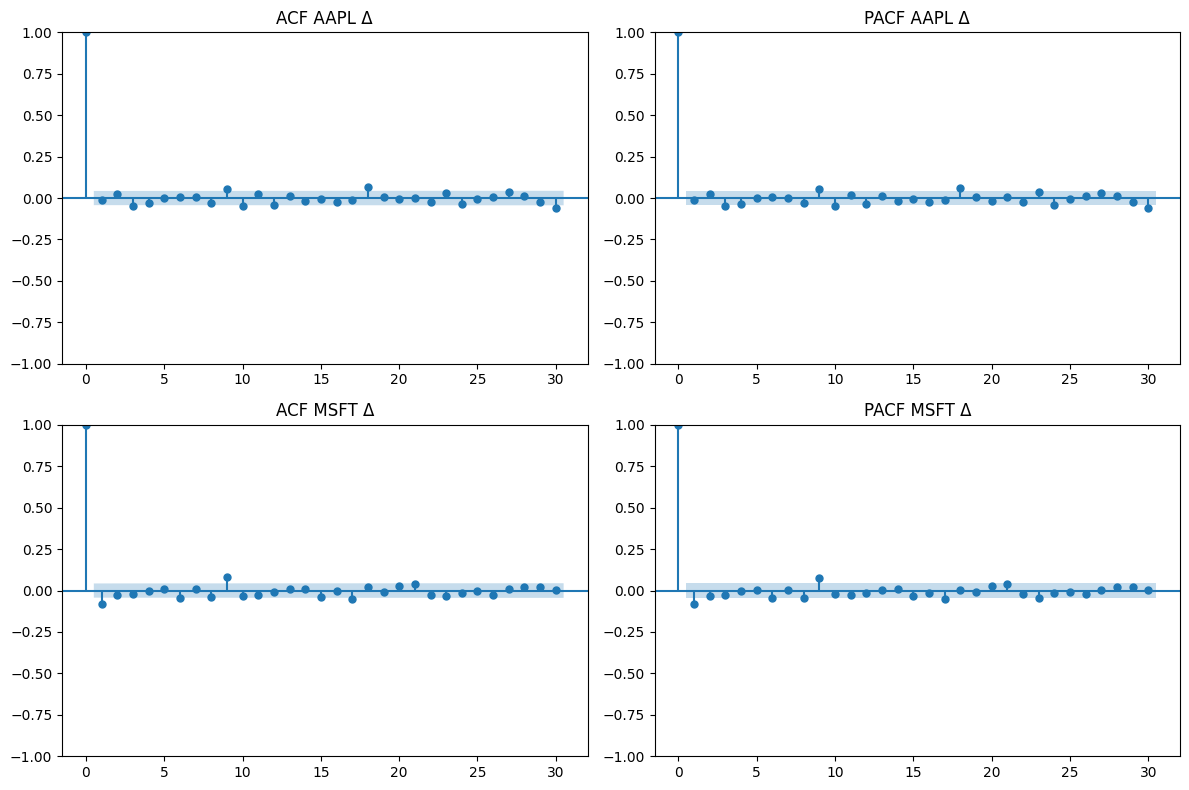

In [252]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
plot_acf(aapl.diff().dropna(), ax=axes[0,0], lags=30, title="ACF AAPL Δ")
plot_pacf(aapl.diff().dropna(), ax=axes[0,1], lags=30, title="PACF AAPL Δ")
plot_acf(msft.diff().dropna(), ax=axes[1,0], lags=30, title="ACF MSFT Δ")
plot_pacf(msft.diff().dropna(), ax=axes[1,1], lags=30, title="PACF MSFT Δ")
plt.tight_layout()
plt.show()

In [253]:
# Берём первую разность
aapl_stat = aapl.diff().dropna()
msft_stat = msft.diff().dropna()

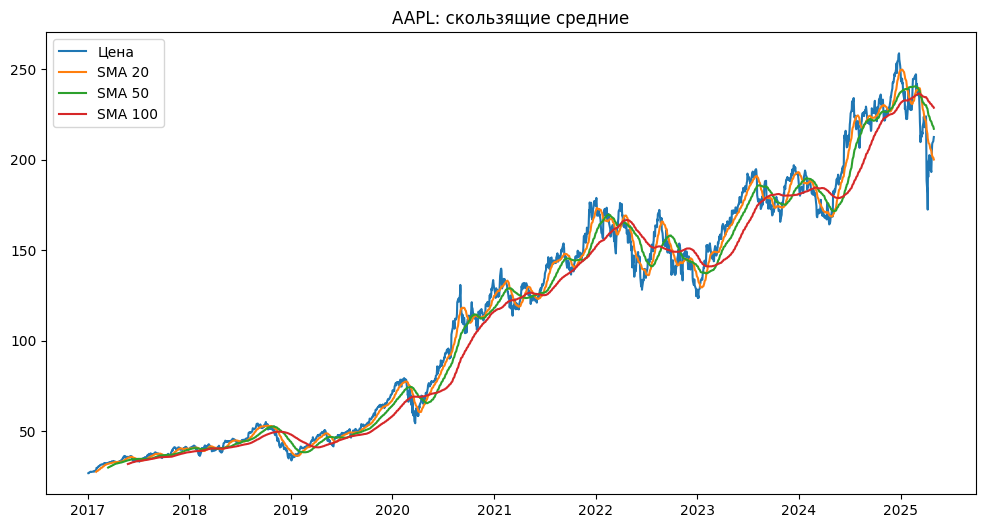

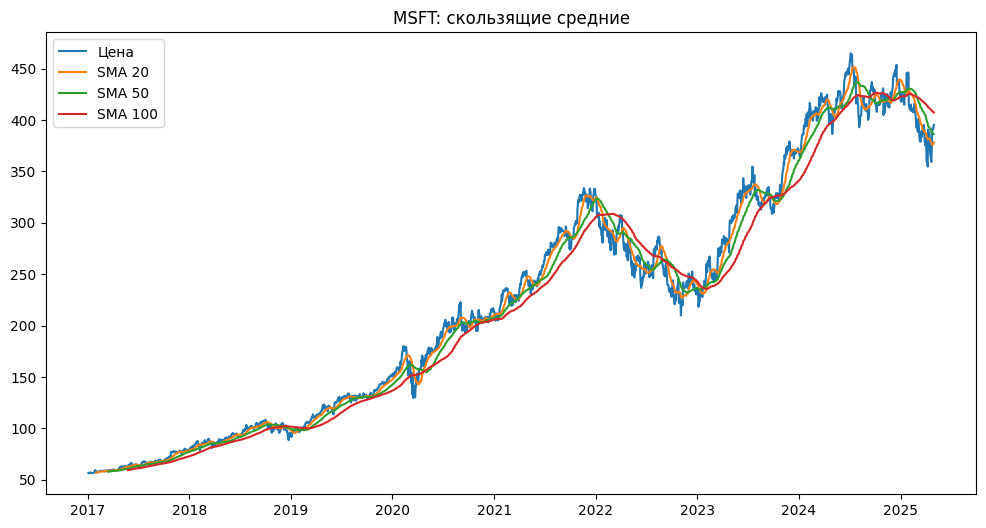

In [254]:
#Вычисление скользящих средних и визуализация
# Параметры окон
windows = [20, 50, 100]

# Функция для расчёта SMA
def compute_sma(ts, window):
    return ts.rolling(window=window).mean()

# Расчёт для AAPL и MSFT
sma = {ticker: {w: compute_sma(data[ticker], w) for w in windows} for ticker in ['AAPL', 'MSFT']}

for ticker in ['AAPL', 'MSFT']:
    plt.figure(figsize=(12, 6))
    plt.plot(data[ticker], label='Цена')
    for w in windows:
        plt.plot(sma[ticker][w], label=f'SMA {w}')
    plt.title(f'{ticker}: скользящие средние')
    plt.legend()
    plt.show()

In [264]:
# Тесты на гетероскедастичность
# Тест ARCH LM
# Доходности
returns = data.pct_change().dropna()

# Функция теста ARCH
def arch_lm_test(ts, lags=12):
    test = het_arch(ts, nlags=lags)
    print(f'ARCH LM: LM-stat = {test[0]:.4f}, p-value = {test[1]:.4f}')

print('=== AAPL Returns ===')
arch_lm_test(returns['AAPL'])
print('\n=== MSFT Returns ===')
arch_lm_test(returns['MSFT'])

=== AAPL Returns ===
ARCH LM: LM-stat = 279.2795, p-value = 0.0000

=== MSFT Returns ===
ARCH LM: LM-stat = 561.1632, p-value = 0.0000


#Выводы
# Анализ доходностей акций AAPL и MSFT

## 1. Средняя доходность (Mean)
**Средняя доходность** — это просто арифметическое среднее всех ежедневных изменений цен, то есть ожидаемый «типичный» результат за день. Она рассчитывается как сумма всех процентных изменений, делённая на количество дней .

- **AAPL**: 0.1169 % — в среднем цена AAPL росла на ~0,12 % в день.
- **MSFT**: 0.1082 % — соответствующий показатель для MSFT чуть ниже, ~0,11 % ежедневно.

## 2. Волатильность (StdDev)
**Стандартное отклонение** измеряет, насколько сильно отдельные ежедневные доходности «разбросаны» вокруг среднего. Это главный прокси-показатель риска: чем выше StdDev, тем более непредсказуемы колебания цены.

- **AAPL**: 1.8965 % — среднедневное отклонение доходностей почти 1,9 %.
- **MSFT**: 1.7464 % — чуть более «спокойная» волатильность у Microsoft.

## 3. Минимум и максимум (Min, Max)
Эти показатели показывают, насколько далеко доходности отклонялись в худшую и лучшую стороны за весь период:

- **AAPL**: от –12,86 % до +15,33 % за один торговый день.
- **MSFT**: от –14,74 % до +14,22 % за один день.

Такие экстремумы часто связывают с выходом важных новостей, отчётов или общерыночными потрясениями.

## 4. Асимметрия (Skewness)
**Skewness** измеряет «смещённость» распределения доходностей относительно среднего:

- **Положительная асимметрия (>0)**: длинный правый хвост (частые небольшие убытки и редкие крупные выигрыши).
- **Отрицательная асимметрия (<0)**: частые небольшие выигрыши и редкие крупные просадки.

- **AAPL (0.140)** и **MSFT (0.063)**: асимметрия слегка положительная, то есть обе акции имели больше мелких убытков и пару крупных «рывков» вверх.

## 5. Эксцесс (Kurtosis)
**Kurtosis** показывает «пикообразность» и «ширину хвостов» распределения:

- **Мезокуртическое (≈3)**: соответствует нормальному распределению.
- **Лептокуртическое (>3)**: «толстые» хвосты, больше экстремальных событий.
- **Платикуртическое (<3)**: «тонкие» хвосты, редкие экстремумы.

- **AAPL (6.882)** и **MSFT (7.507)**: эксцесс существенно выше 3 — это указывает на частые «чёрные лебеди» (резкие большие движения) в доходностях обоих активов.



# Интерпретация результатов ADF-теста

## 1. Исходные ряды

**Нулевая гипотеза (H₀):** наличие единичного корня (ряд нестационарен) .

### AAPL
- **ADF Statistic:** –0.6696  
- **p-value:** 0.8545  
- **Интерпретация:** p-value значительно выше стандартного уровня значимости (0.05), поэтому нет оснований отвергнуть H₀. Ряд AAPL **нестационарен**.

### MSFT
- **ADF Statistic:** –0.6508  
- **p-value:** 0.8591  
- **Интерпретация:** аналогично AAPL, высокий p-value указывает на сохранение единичного корня. Ряд MSFT **нестационарен**.

**Вывод:** Исходные ряды содержат трендовые или случайные блуждающие компоненты и требуют преобразования для стационарности.

---

## 2. Первые разности (Δ)

### AAPL (первые разности)
- **ADF Statistic:** –14.9274  
- **p-value:** ≈ 0.0000  
- **Интерпретация:** крайне низкий p-value позволяет отвергнуть H₀. Ряд первых разностей AAPL **стационарен**.

### MSFT (первые разности)
- **ADF Statistic:** –15.2757  
- **p-value:** ≈ 0.0000  
- **Интерпретация:** аналогично AAPL, ряд первых разностей MSFT **стационарен**.

**Вывод:** Дифференцирование (первые разности) устранило единичный корень, что необходимо для корректного анализа моделями временных рядов (например, ARIMA)

# KPSS-тест: Проверка стационарности

**KPSS (Kwiatkowski–Phillips–Schmidt–Shin)** — статистический тест, противоположный ADF.  
**Нулевая гипотеза (H₀):** ряд стационарен вокруг постоянной или тренда.  

**Правило:**  
Если p-value < 0.05 → отвергаем H₀ (ряд **нестационарен**).  

---

## 🔹 KPSS на исходных рядах

| Ряд   | Статистика | p-value | Вывод                     |
|-------|------------|---------|---------------------------|
| AAPL  | 6.9780     | 0.0100  | Отвергаем H₀ → **нестационарный** |
| MSFT  | 6.8816     | 0.0100  | Отвергаем H₀ → **нестационарный** |

**Интерпретация:**  
Исходные ряды AAPL и MSFT не являются стационарными (подтверждает результаты ADF-теста).  

---

## KPSS на первых разностях (Δ)

| Ряд      | Статистика | p-value | Вывод                   |
|----------|------------|---------|-------------------------|
| AAPL Δ   | 0.0342     | 0.1000  | Не отвергаем H₀ → **стационарен** |
| MSFT Δ   | 0.0444     | 0.1000  | Не отвергаем H₀ → **стационарен** |

**Интерпретация:**  
После первого дифференцирования оба ряда становятся стационарными.  

---

## Общие выводы

1. **Согласованность с ADF:**  
   Результаты KPSS и ADF-теста согласуются:  
   - Исходные ряды — **нестационарны**,  
   - Первые разности — **стационарны**.  

2. **Подтверждение необходимости преобразований:**  
   Для корректного моделирования (например, ARIMA) следует использовать разностные стационарные ряды.  

3. **Сила комбинированного подхода:**  
   Использование ADF и KPSS в паре повышает надёжность диагностики:  
   - ADF отвергает наличие стационарности,  
   - KPSS подтверждает её после дифференцирования.

# Результаты теста ARCH-LM и их интерпретация

Тест ARCH-LM оценивает наличие **условной гетероскедастичности** (автокорреляции волатильности) в рядах доходностей.

**Нулевая гипотеза (H₀):** Нет ARCH-эффектов (остатки гомоскедастичны).  
**Критерий:** Если p-value < 0.05 → отвергаем H₀ (присутствует условная гетероскедастичность).

---

## 1. Результаты теста

| Ряд     | LM-Statistic | p-value  | Вывод                                  |
|---------|--------------|----------|----------------------------------------|
| AAPL Δ  | 279.2795     | 0.0000   | p < 0.05 → **отвергаем H₀** → есть ARCH-эффекты |
| MSFT Δ  | 561.1632     | 0.0000   | p < 0.05 → **отвергаем H₀** → есть ARCH-эффекты |

---

## 2. Интерпретация результатов

- **Высокие значения LM-Statistic** (279.28 и 561.16) указывают на **сильную автокорреляцию квадратов остатков** — типичный признак кластеризации волатильности в финансовых данных.
- **p-value ≈ 0** означает статистически значимое отклонение от H₀ (>99% уверенности) — гетероскедастичность подтверждена.
- **ARCH-эффекты** свидетельствуют, что:
  - Волатильность доходностей **изменяется во времени**,
  - Зависит от прошлых значений ошибок (инерция волатильности),
  - Не является постоянной (нарушение предпосылок классических моделей).

---

## 3. Практические выводы и рекомендации

1. **Применение GARCH-моделей:**
   - Результаты обосновывают использование **ARCH/GARCH**-семейства моделей для:
     - Моделирования кластеризации волатильности,
     - Прогнозирования рисков (например, VaR),
     - Учета зависимости дисперсии от прошлых шоков.

2. **Дополнительные проверки:**
   - Рекомендуется провести тесты на асимметричные эффекты (EGARCH, TGARCH) — для учета разного влияния "плохих" и "хороших" новостей на волатильность.

3. **Для трейдинга и риск-менеджмента:**
   - Учет ARCH-эффектов улучшает оценку рисков,
   - Позволяет выявлять периоды повышенной нестабильности рынка.

---

In [268]:
#Задание 2:
#выберу Apple ( AAPL)

Arima D-value: 1
Root Mean Squared Error:  26.5893286574574
Mean Absolute Error:  24.316723364009448
Root Mean Squared Error:  27.11367406078863
Mean Absolute Error:  21.255544557488566
Root Mean Squared Error:  19.78110858893432
Mean Absolute Error:  15.738508778585985
Root Mean Squared Error:  31.704200907547786
Mean Absolute Error:  28.69550217994952


,Horizon,RMSE,MAE
0,1 месяц (21 дн),26.589329,24.316723
1,3 месяца (63 дн),27.113674,21.255545
2,6 месяцев (126 дн),19.781109,15.738509
3,1 год (252 дн),31.704201,28.695502


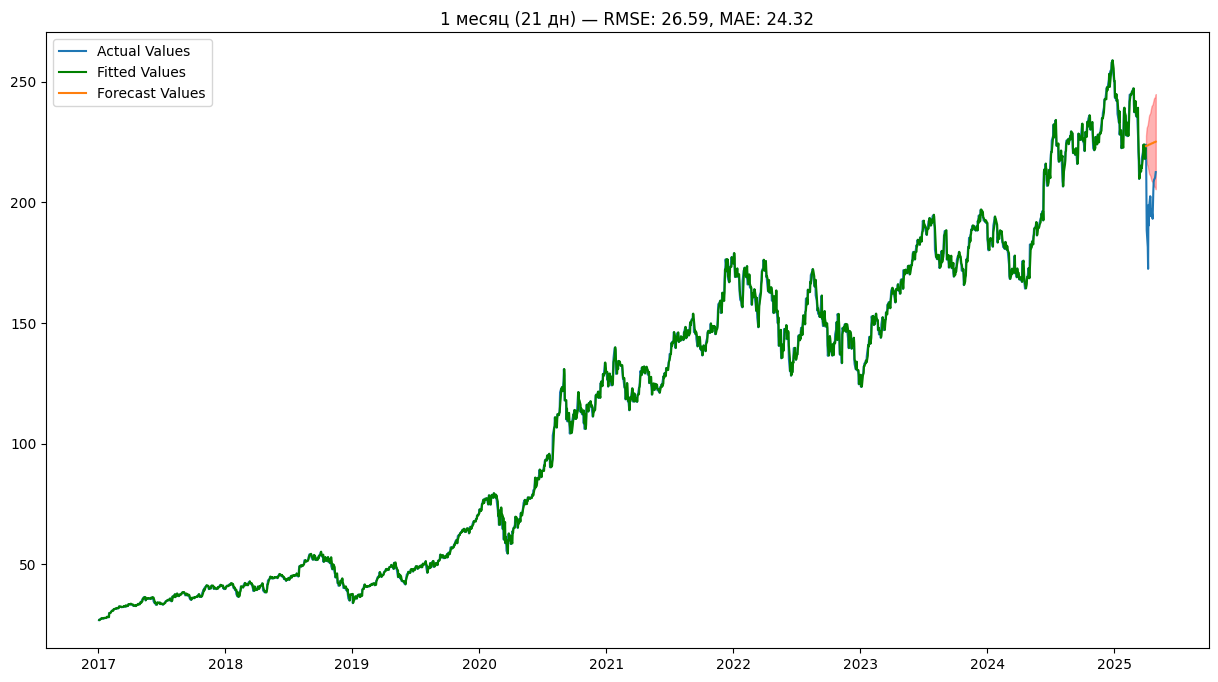

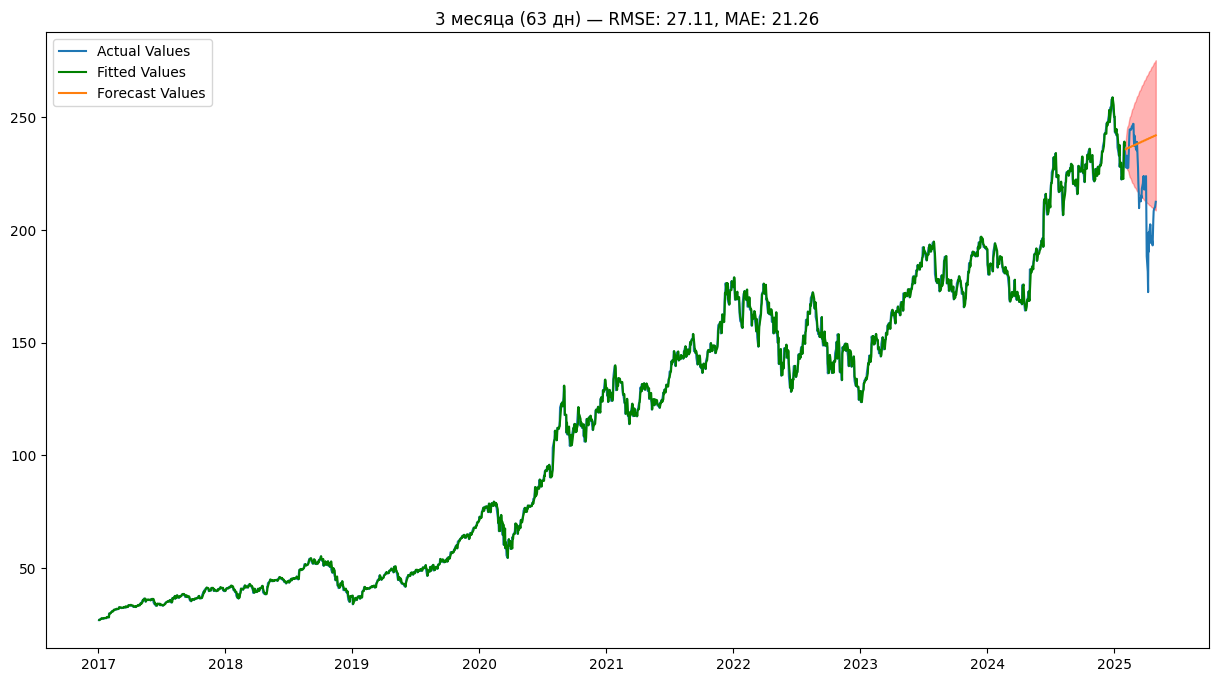

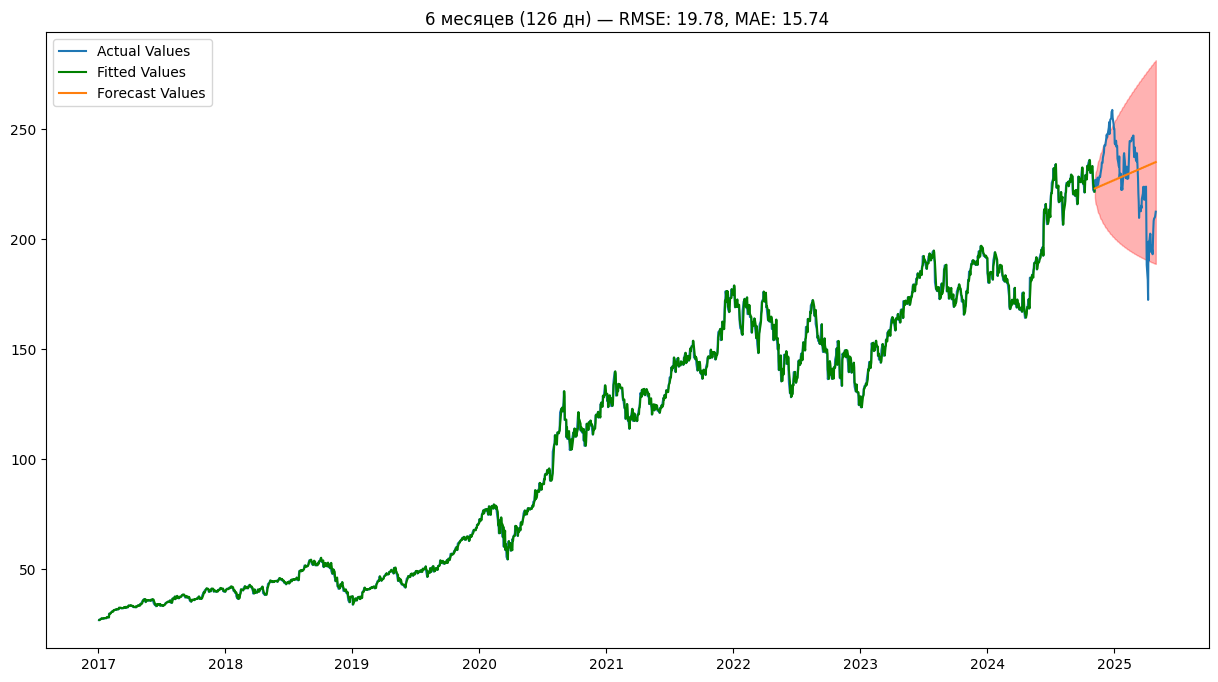

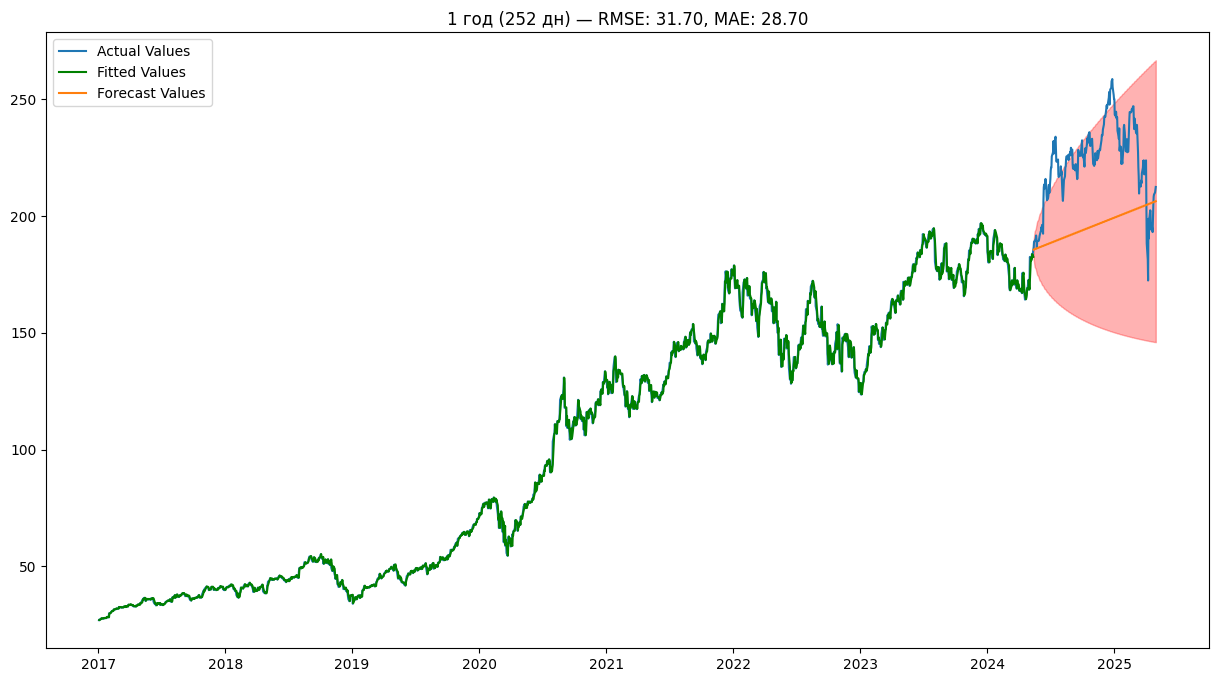

In [384]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import pmdarima as pm
from pmdarima.arima.utils import ndiffs


def plot_result(model, data,name , Ntest):
    
    params = model.get_params()
    d = params['order'][1]
    
    #In sample data prediction
    train_pred = model.predict_in_sample(start=d, end=-1)
    #out of sample prediction
    test_pred, conf = model.predict(n_periods=Ntest, return_conf_int=True)
   
    #evaluating the model using RMSE and MAE metrics
    y_true = test.values
    rmse = np.sqrt(mean_squared_error(y_true,test_pred))
    mae = mean_absolute_error(y_true,test_pred)

    #plotting real values, fitted values and prediction values
    fig, ax= plt.subplots(figsize=(15,8))
    ax.plot(data.index, data, label='Actual Values')
    ax.plot(train.index[d:], train_pred, color='green', label='Fitted Values')
    ax.plot(test.index, test_pred, label='Forecast Values')
    ax.set_title(f'{name} — RMSE: {rmse:.2f}, MAE: {mae:.2f}')
    ax.fill_between(test.index, conf[:,0], conf[:,1], color='red', alpha=0.3)
    ax.legend()

    return rmse, mae


#print(aapl)
d_val = ndiffs(aapl, test='adf')
print('Arima D-value:', d_val)

# Подготовка данных

# Задаём горизонты прогнозов (в рабочих днях)
horizons = {
    '1 месяц (21 дн)':   21,
    '3 месяца (63 дн)':  63,
    '6 месяцев (126 дн)': 126,
    '1 год (252 дн)':     252
}
results = []

for name, Ntest in horizons.items():
    
    train = aapl.iloc[:-Ntest]
    test = aapl.iloc[-Ntest:]
    train_idx = aapl.index <= train.index[-1]
    test_idx = aapl.index > train.index[-1]
    
    #auto-arima
    model = pm.auto_arima(train,
                          d = d_val,
                          start_p = 0,
                          max_p = 15,
                          start_q = 0,
                          max_q = 15,
                          stepwise=True,
                          max_order=30,
                          trace=False)
    
    model.get_params()
    
    rmse , mae = plot_result(model, aapl, name, Ntest=Ntest)
    print('Root Mean Squared Error: ', rmse)
    print('Mean Absolute Error: ', mae)
    results.append({'Horizon': name, 'RMSE': rmse, 'MAE': mae})

# Сводная таблица результатов
df_results = pd.DataFrame(results)
display(df_results)


# Анализ прогнозирования временных рядов с использованием ARIMA

## Результаты прогнозирования

### Краткосрочный прогноз (1–3 мес.)
- **RMSE**: ≈ 26–27
- **MAE**: ≈ 21–24

**Наблюдения**:  
Ошибки относительно невелики, но заметна тенденция - при удвоении горизонта с 1 до 3 месяцев MAE не растёт линейно. Это может свидетельствовать о:
- Эффектах сглаживания
- Локальной стационарности цен

### Среднесрочный прогноз (6 мес.)
- **RMSE**: 19.78
- **MAE**: 15.74 (наименьшие среди всех горизонтов)

**Интерпретация**:  
Парадоксальное снижение ошибок объясняется тем, что ARIMA-модель:
1. Лучше улавливает тренды на полугодичных интервалах
2. На коротких горизонтах доминирует шум
3. На длинных горизонтах накапливаются структурные сдвиги

### Долгосрочный прогноз (1 год)
- **RMSE**: ≈ 31.70
- **MAE**: ≈ 28.70 (максимальные ошибки)

**Объяснение**:  
Традиционно меньшая точность обусловлена:
- Увеличивающейся неопределённостью
- Возможными сменами трендов
- Накоплением ошибок прогнозирования 

In [ ]:
#Задание 3:

In [395]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor as lgr
import lightgbm as lgb
from catboost import CatBoostRegressor as cbr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNet
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV , StratifiedKFold
from sklearn.metrics import explained_variance_score,r2_score,mean_squared_error,mean_absolute_error

In [397]:
# Читаем данные
data_wind = pd.read_csv('data.csv')
data_wind.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [399]:
#данные каждые 15 минут
data_wind.shape

(385566, 2)

In [401]:
data_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [403]:
data_wind.rename(columns={'dt':'datetime','MW':'power'},inplace=True)
data_wind['datetime'] = pd.to_datetime(data_wind['datetime'])
data_wind['power'] = data_wind['power'].astype('float64')
data_wind.dtypes

datetime    datetime64[ns]
power              float64
dtype: object

In [405]:
print(f'Данные доступны с {data_wind.datetime.min()} до {data_wind.datetime.max()}')

Данные доступны с 2011-01-01 00:00:00 до 2021-12-30 07:45:00


In [409]:
days = data_wind.shape[0]//96 # 96 отсчетов в день
print(f'Количество дней в наборе данных равно {days}')

Количество дней в наборе данных равно 4016


In [411]:
data_wind['power'].describe()

count    385566.000000
mean       3183.560481
std        3045.941591
min           0.000000
25%         905.000000
50%        2164.000000
75%        4529.877500
max       16727.500000
Name: power, dtype: float64

In [413]:
print(f' Максимальная вырабатываемая мощность была на \n{data_wind.loc[data_wind.power==data_wind.power.max()]}')

 Максимальная вырабатываемая мощность была на 
                  datetime    power
378846 2021-10-21 09:00:00  16727.5


In [415]:
data_wind.isna().sum()

datetime    0
power       0
dtype: int64

In [417]:
#В наборе данных нет пропущенных значений.

In [419]:
tb = np.arange(1,data_wind.shape[0]+1)
data_wind['tb'] = tb

In [421]:
data_wind['weekday'] = data_wind['datetime'].dt.day_name()
data_wind['month'] = data_wind['datetime'].dt.month_name()
data_wind['year'] = data_wind['datetime'].dt.year.astype('string')
data_wind['hour'] = data_wind['datetime'].dt.strftime('%H').astype('string')

In [423]:
data_wind

,datetime,power,tb,weekday,month,year,hour
0,2011-01-01 00:00:00,3416.00,1,Saturday,January,2011,00
1,2011-01-01 00:15:00,4755.00,2,Saturday,January,2011,00
2,2011-01-01 00:30:00,4939.00,3,Saturday,January,2011,00
3,2011-01-01 00:45:00,4939.00,4,Saturday,January,2011,00
4,2011-01-01 01:00:00,4998.00,5,Saturday,January,2011,01
...,...,...,...,...,...,...,...
385561,2021-12-30 06:45:00,8140.31,385562,Thursday,December,2021,06
385562,2021-12-30 07:00:00,8162.33,385563,Thursday,December,2021,07
385563,2021-12-30 07:15:00,8405.11,385564,Thursday,December,2021,07
385564,2021-12-30 07:30:00,8503.48,385565,Thursday,December,2021,07


In [425]:
data_wind.weekday.unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

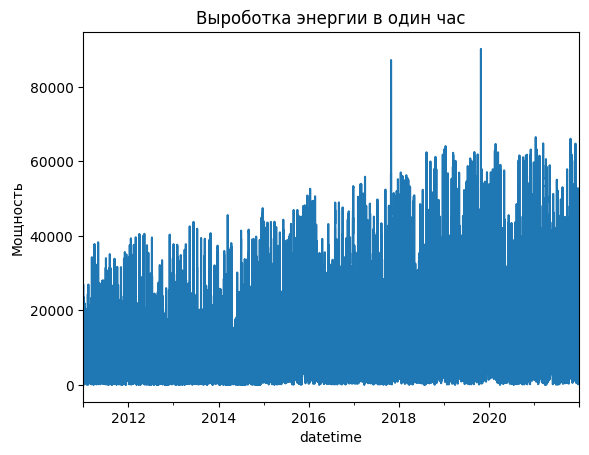

In [427]:
group_df = (data_wind.set_index('datetime')).resample('H')['power'].sum()
group_df.plot(kind='line')
plt.ylabel('Мощность')
plt.title('Выроботка энергии в один час')
plt.show()

In [429]:
#В 2017 и 2019 годах наблюдался огромный скачок в выработке электроэнергии в час.
data_wind.rename(columns={'power':"power"},inplace=True)

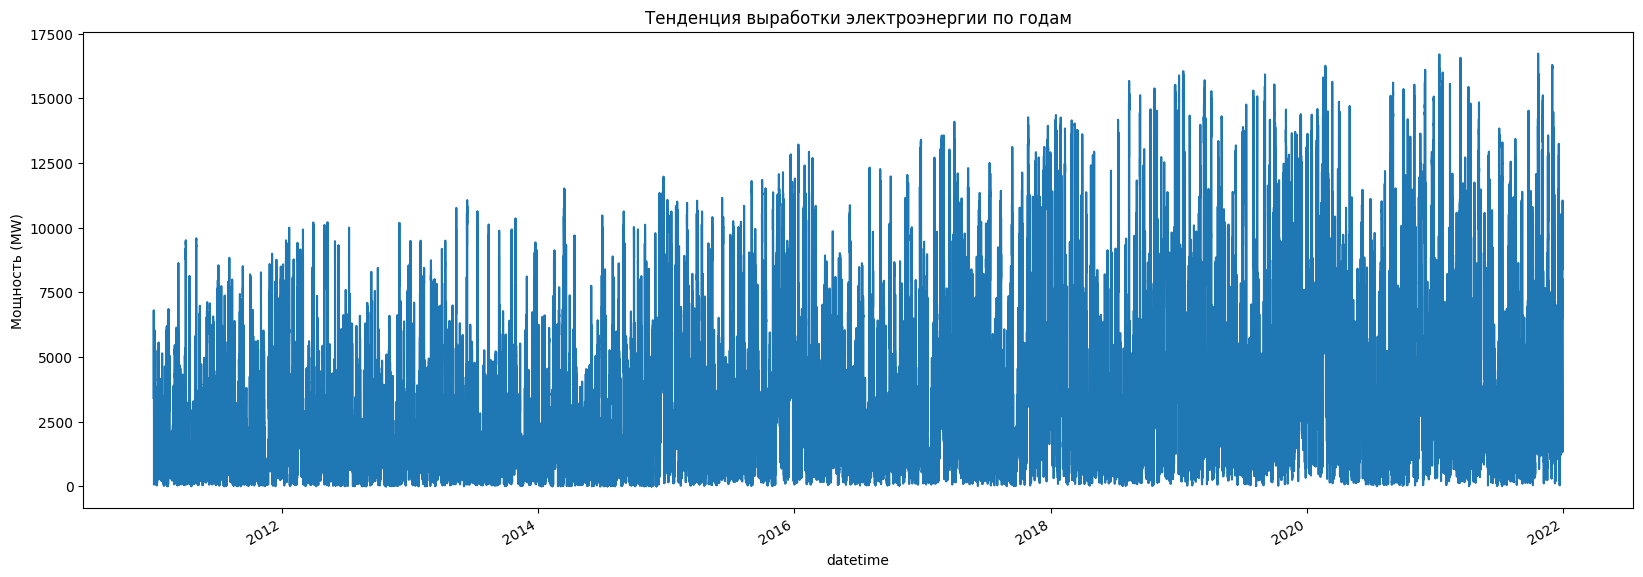

In [433]:
fig , axes = plt.subplots(1,1,figsize=(20,7))
data_wind.set_index('datetime')['power'].plot()
plt.ylabel('Мощность (MW)')
plt.title('Тенденция выработки электроэнергии по годам')
plt.show()

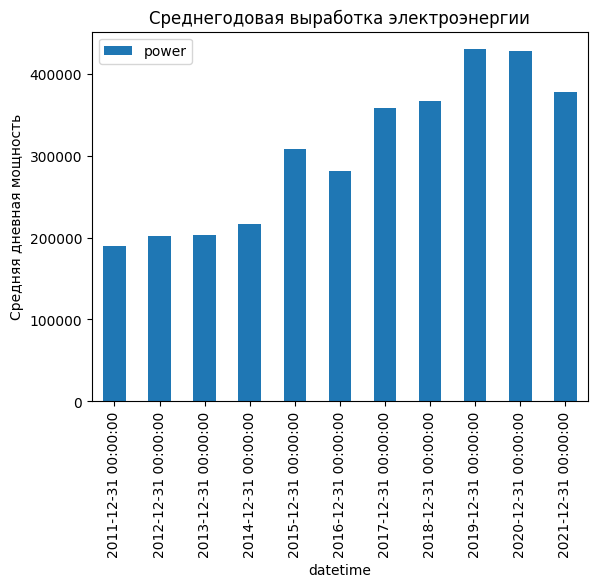

In [441]:
year_df = pd.DataFrame(data_wind.set_index('datetime').resample('1D')['power'].sum()).resample('1Y').mean()
year_df.plot.bar()
plt.title("Среднегодовая выработка электроэнергии")
plt.ylabel("Средняя дневная мощность")
plt.show()

In [ ]:
#Максимальное производство электроэнергии пришлось на 2019 и 2020 годы.

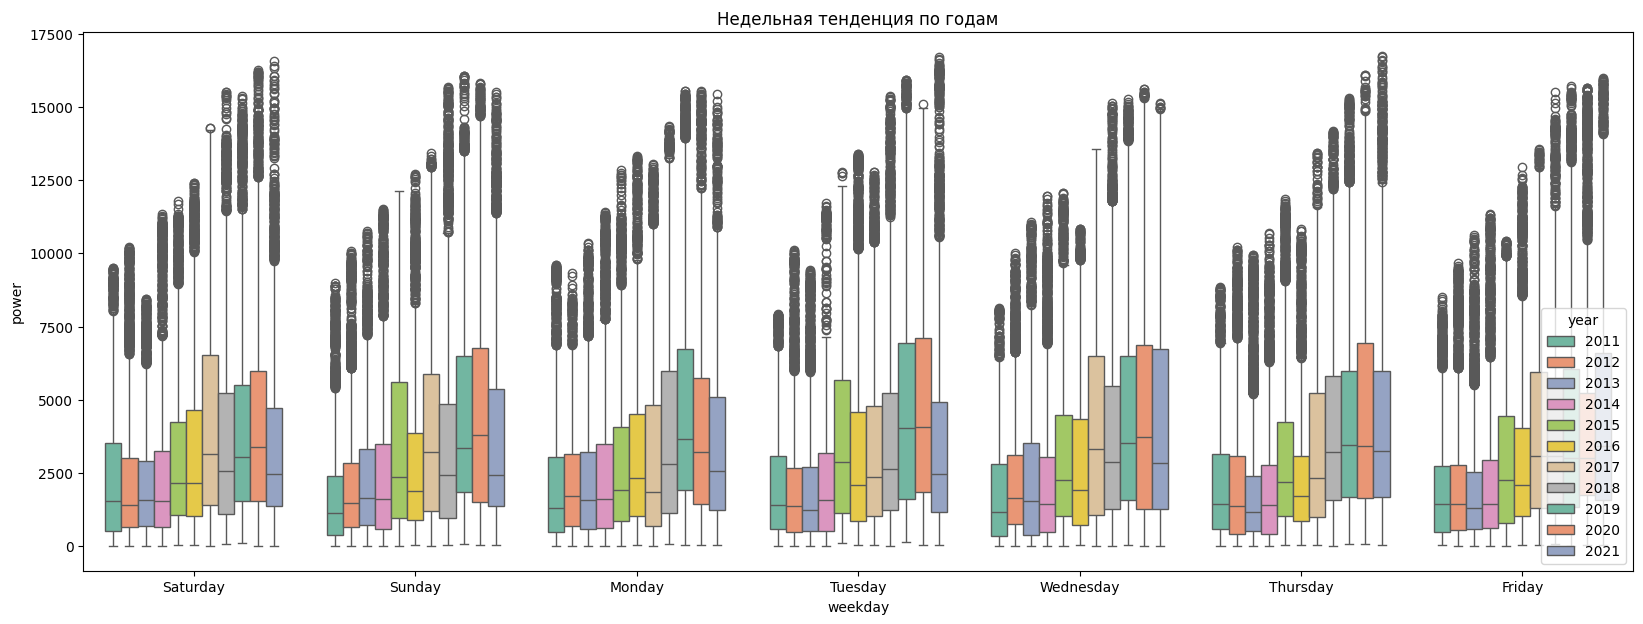

In [445]:
fig,axes = plt.subplots(1,1,figsize=(20,7))
sns.boxplot(data = data_wind,x='weekday',y='power',hue='year',palette='Set2',ax=axes)
plt.title('Недельная тенденция по годам')
plt.show()

In [ ]:
    #Общая сумма электроэнергии, выработанной во вторник, четверг, пятницу и субботу, была самой высокой в 2021 году. 
    #Общая сумма электроэнергии, выработанной в понедельник и воскресенье, была самой высокой в 2019 году.

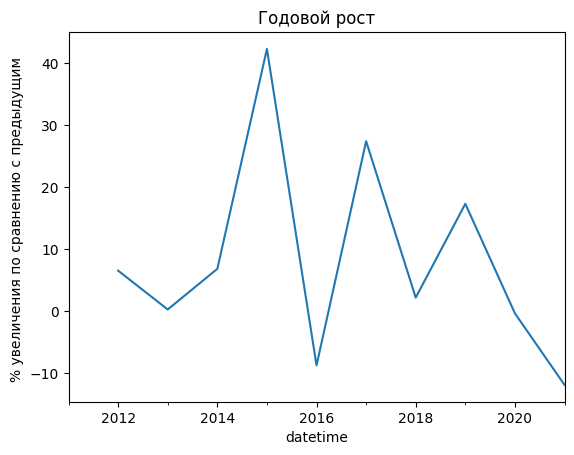

In [447]:
#Годовой рост выработки электроэнергии
year_df = pd.DataFrame(data_wind.set_index('datetime').resample('1D')['power'].sum()).resample("1Y").mean()
year_df['shifted'] = year_df.shift(1)
year_df['YoYGrowth'] = ((year_df['power'] - year_df['shifted'])/year_df['shifted'])*100
year_df['YoYGrowth'].plot()
plt.title("Годовой рост")
plt.ylabel("% увеличения по сравнению с предыдущим ")
plt.show()

In [ ]:
#В 2015 и 2017 годах зафиксирован самый высокий процент прироста мощности по сравнению с предыдущим годом — на 35%

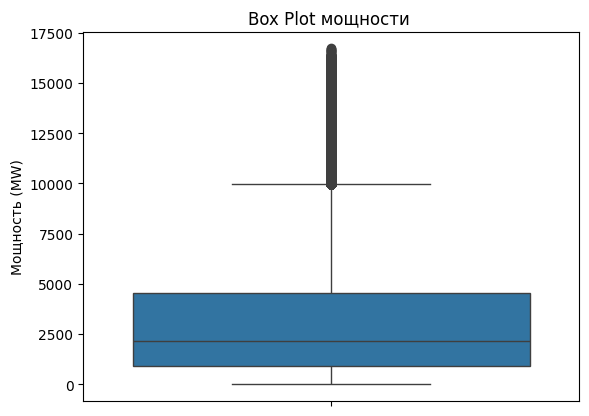

In [449]:
#Обнаружение выбросов
sns.boxplot(data=data_wind['power'])
plt.title('Box Plot мощности ')
plt.ylabel('Мощность (MW)')
plt.show()

In [ ]:
#На диаграмме видно, что значения мощности выше 10000 МВт являются выбросами.

In [451]:
Q1= data_wind.power.quantile(0.25) 
Q3= data_wind.power.quantile(0.75) 
IQR = Q3-Q1
data_wind['IQR_OUTLIER_FLAG'] = (data_wind.power>(Q3+IQR*1.5)) | (data_wind.power< 0)
print(f"Верхний ус {Q3+IQR*1.5} , нижний 0")
print(f"Количество выбросов : {data_wind['IQR_OUTLIER_FLAG'].sum()}")

Верхний ус 9967.193750000002 , нижний 0
Количество выбросов : 18036


In [453]:
#Добавим признаки
wind_data  = data_wind.copy()
wind_data['feat_monthName'] = wind_data['datetime'].dt.month
wind_data['feat_isNight'] = (wind_data['datetime'].dt.hour>17).astype(int)
wind_data['feat_isDawn'] = ((wind_data['datetime'].dt.hour<=6) &  (wind_data['datetime'].dt.hour>=0) ).astype(int)
wind_data['feat_isMorning'] = ((wind_data['datetime'].dt.hour>6) &  (wind_data['datetime'].dt.hour<=12) ).astype(int)
wind_data['feat_isAfternoon'] = ((wind_data['datetime'].dt.hour>12) &  (wind_data['datetime'].dt.hour<=16) ).astype(int)

wind_data.head()


,datetime,power,tb,weekday,month,year,hour,IQR_OUTLIER_FLAG,feat_monthName,feat_isNight,feat_isDawn,feat_isMorning,feat_isAfternoon
0,2011-01-01 00:00:00,3416.0,1,Saturday,January,2011,00,False,1,0,1,0,0
1,2011-01-01 00:15:00,4755.0,2,Saturday,January,2011,00,False,1,0,1,0,0
2,2011-01-01 00:30:00,4939.0,3,Saturday,January,2011,00,False,1,0,1,0,0
3,2011-01-01 00:45:00,4939.0,4,Saturday,January,2011,00,False,1,0,1,0,0
4,2011-01-01 01:00:00,4998.0,5,Saturday,January,2011,01,False,1,0,1,0,0


In [455]:
#Добавим сдвиги 1,12,24,28,48,72
for x in [1,12,24,48,72]:
    wind_data[f'lagged_power_{x}'] = wind_data.power.shift(x).bfill()

#и пару скользящих средних
#Скользящее среднее помогает сгладить шум в данных и более эффективно улавливает базовую тенденцию. 
wind_data['rolling_4_power_mean'] = wind_data.power.rolling(4, 1).mean().shift().bfill()
wind_data['rolling_24_power_mean'] = wind_data.power.rolling(24, 1).mean().shift().bfill()

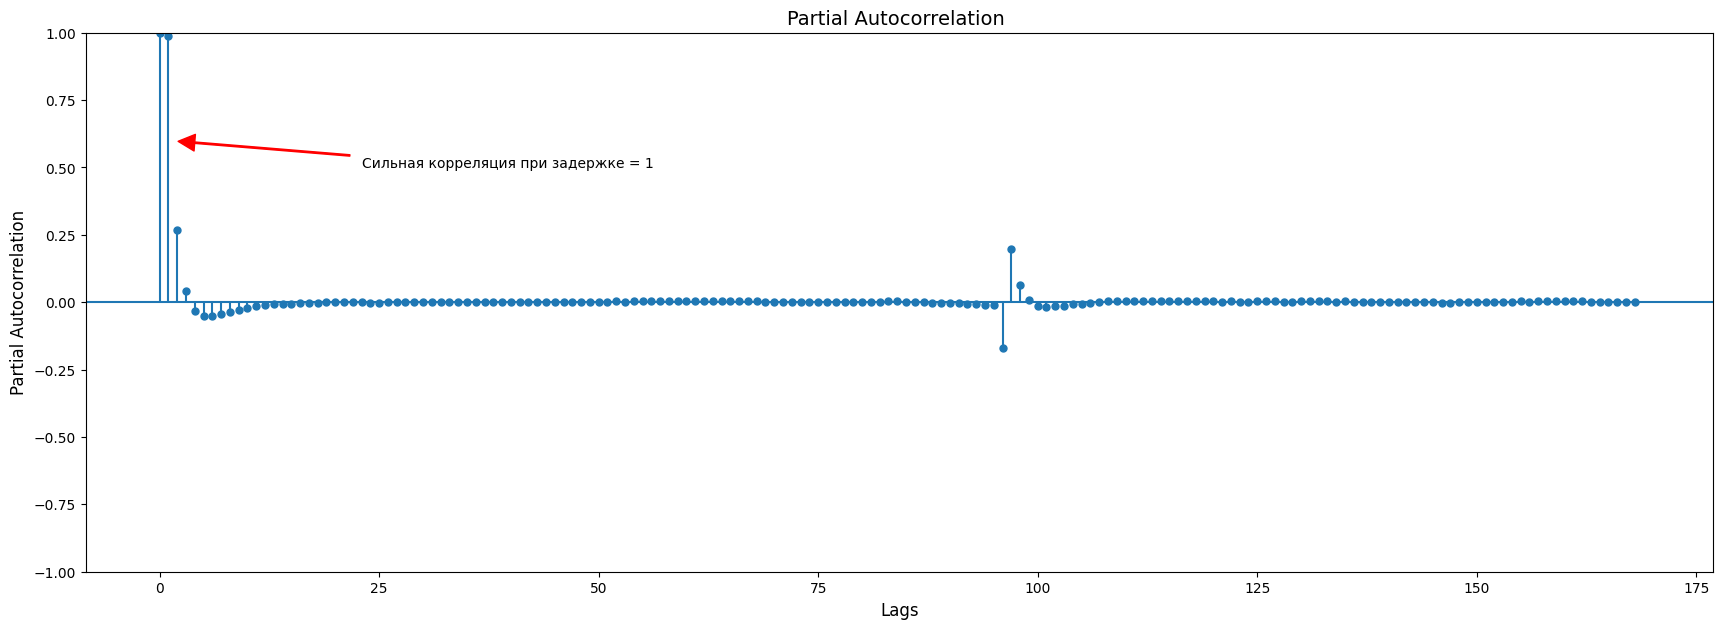

In [459]:
from statsmodels.graphics.tsaplots import plot_pacf
dataframe = wind_data.set_index('datetime')
plt.rc("figure", figsize=(21, 7))
plot_pacf(dataframe.power, lags=24*7)

plt.annotate('Сильная корреляция при задержке = 1', xy=(1, 0.6),  xycoords='data', \
            xytext=(0.17, 0.75), textcoords='axes fraction', \
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.xlabel('Lags', fontsize=12)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.title(f'Partial Autocorrelation ', fontsize=14)
plt.show()

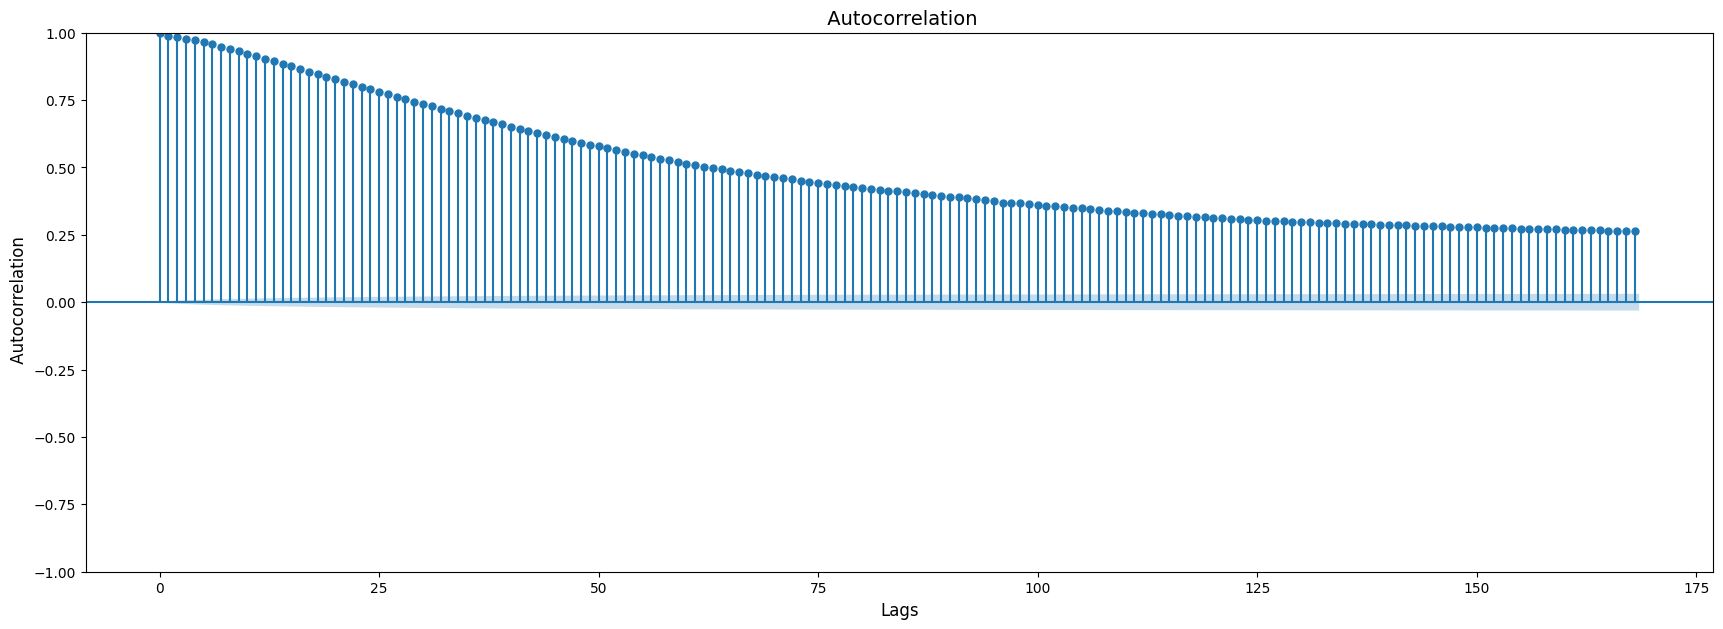

In [461]:
from statsmodels.graphics.tsaplots import plot_acf
dataframe = wind_data.set_index('datetime')
plt.rc("figure", figsize=(21, 7))
plot_acf(dataframe.power, lags=24*7)
plt.xlabel('Lags', fontsize=12)
plt.ylabel(' Autocorrelation', fontsize=12)
plt.title(f' Autocorrelation', fontsize=14)
plt.show()

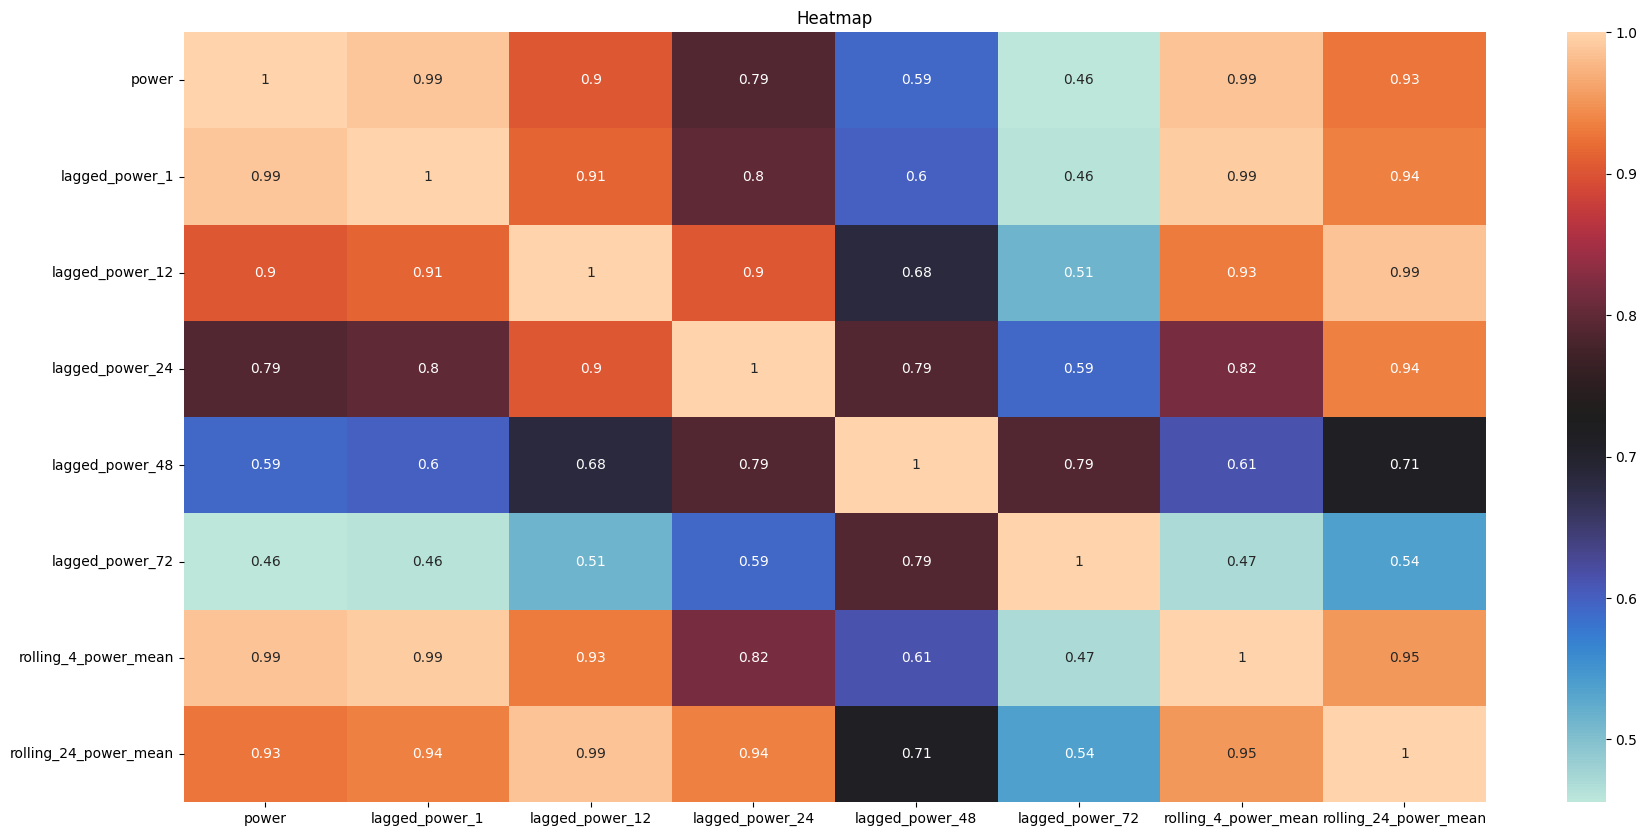

In [463]:
cor = wind_data.filter(regex='power').corr()
fig,axes = plt.subplots(1,1,figsize=(21,10))
sns.heatmap(cor,annot=True, cmap ='icefire')
plt.title('Heatmap')
plt.show()

In [538]:
#lagged_power_1 , lagged_power_12 , rolling_4_power_mean , rolling_24_power_mean — это характеристики, сильно коррелирующие с характеристикой мощности.
print(f'Все фичи {wind_data.columns}')

Все фичи Index(['datetime', 'power', 'tb', 'weekday', 'month', 'year', 'hour',
       'IQR_OUTLIER_FLAG', 'feat_monthName', 'feat_isNight', 'feat_isDawn',
       'feat_isMorning', 'feat_isAfternoon', 'lagged_power_1',
       'lagged_power_12', 'lagged_power_24', 'lagged_power_48',
       'lagged_power_72', 'rolling_4_power_mean', 'rolling_24_power_mean',
       'ramp'],
      dtype='object')


In [540]:
#Прогнозирование целевой переменной на 8 временных блоков вперед - 2 часа
train_data = pd.DataFrame()
target_ahead_timeblocks = 8 
wind_data['ramp'] = wind_data['power'] - wind_data['power'].shift(target_ahead_timeblocks)
features = ['datetime', 'power','tb',\
        'feat_monthName', 'feat_isNight', 'feat_isDawn',\
       'feat_isMorning', 'feat_isAfternoon', 'lagged_power_1',\
       'lagged_power_12', 'lagged_power_24', 'lagged_power_48',\
       'lagged_power_72', 'rolling_4_power_mean', 'rolling_24_power_mean']
train_data = wind_data[features].copy()
for feature in train_data.columns:
    train_data[feature] = train_data[feature].shift(-target_ahead_timeblocks )
print(train_data.shape)
train_data.head()

(385566, 15)


,datetime,power,tb,feat_monthName,feat_isNight,feat_isDawn,feat_isMorning,feat_isAfternoon,lagged_power_1,lagged_power_12,lagged_power_24,lagged_power_48,lagged_power_72,rolling_4_power_mean,rolling_24_power_mean
0,2011-01-01 02:00:00,5509.0,9.0,1.0,0.0,1.0,0.0,0.0,5438.0,3416.0,3416.0,3416.0,3416.0,5240.25,4876.250000
1,2011-01-01 02:15:00,5638.0,10.0,1.0,0.0,1.0,0.0,0.0,5509.0,3416.0,3416.0,3416.0,3416.0,5368.00,4946.555556
2,2011-01-01 02:30:00,5582.0,11.0,1.0,0.0,1.0,0.0,0.0,5638.0,3416.0,3416.0,3416.0,3416.0,5481.50,5015.700000
3,2011-01-01 02:45:00,5792.0,12.0,1.0,0.0,1.0,0.0,0.0,5582.0,3416.0,3416.0,3416.0,3416.0,5541.75,5067.181818
4,2011-01-01 03:00:00,5962.0,13.0,1.0,0.0,1.0,0.0,0.0,5792.0,3416.0,3416.0,3416.0,3416.0,5630.25,5127.583333


In [542]:
train_data['target'] = train_data['power'].shift(-target_ahead_timeblocks)

In [544]:
valid_cutoff_date = '2021-01-01 00:00:00'  
test_cutoff = '2021-06-01 00:00:00'  

# 
x = train_data.drop(columns='target').copy()
y = train_data[['datetime', 'target']].copy()

In [546]:
x_train = x[x['datetime'] < valid_cutoff_date].iloc[:,1:].copy()
y_train = y[y['datetime'] < valid_cutoff_date].iloc[:,1:].copy()
x_val = x[(x['datetime']>= valid_cutoff_date) & (x['datetime']< test_cutoff)].iloc[:,1:].copy()
y_val = y[(y['datetime']>= valid_cutoff_date) & (y['datetime']< test_cutoff)].iloc[:,1:].copy()
x_test = x[x['datetime'] >= test_cutoff].iloc[:,1:].copy()
y_test = y[y['datetime'] >= test_cutoff].iloc[:,1:].copy()

In [548]:
def regression_metrics(y_test,y_pred):
    print("MAE:\t",round(mean_absolute_error(y_test,y_pred),4))
    print("MSE:\t",round(mean_squared_error(y_test,y_pred),4))
    print("RMSE:\t",round(np.sqrt(mean_squared_error(y_test,y_pred)),4))

In [550]:
def model_validate(model, param_grid, x_train, y_train, x_test,y_test, model_name, k_folds=4, scoring='neg_mean_squared_error', fit_parameters={}):

    model_cv = GridSearchCV(model, param_grid, cv=k_folds, verbose=False, scoring= scoring, refit=True)
    model_cv.fit(x_train, y_train, **fit_parameters)
    y_train_pred = model_cv.predict(x_train)
    y_test_pred = model_cv.predict(x_test)

    print('MSE = ', np.abs(model_cv.score(x_train, y_train)))
    print("Метрики:")
    regression_metrics(y_train ,y_train_pred)
    
    return model_cv

In [552]:
#Lasso
lasso = Lasso(alpha =0.0005, random_state=20)
param_grid = [{'alpha':[0.0005,0.001, 0.005, 0.01, 0.05, 0.03, 0.1, 0.5, 1]}]

lasso_model = model_validate(lasso, param_grid, x_train, y_train, x_test, y_test, 'Lasso',k_folds=5)

MSE =  982546.0166047066
Метрики:
MAE:	 572.5387
MSE:	 982546.0166
RMSE:	 991.2346


In [553]:
param_grid = {'learning_rate':[0.1], 'num_iterations': [10000], 'n_estimators': [25], 'num_leaves': [40],'verbose': [-1],'colsample_bytree':[0.4], 'subsample': [0.4], 'max_depth': [9]} 
lgb_model = lgr()
model_lgb = model_validate(lgb_model, param_grid, x_train, y_train, x_test, y_test, 'LGBM', fit_parameters={'eval_set':[(x_val, y_val)], 'eval_metric':'rmse'})


MSE =  131349.5094066037
Метрики:
MAE:	 224.4069
MSE:	 131349.5094
RMSE:	 362.4217


In [554]:
#CatBoost
cat = cbr(loss_function='RMSE',learning_rate=0.01,max_depth=7,iterations=1500) 

catreg = cat.fit(x_train,y_train,verbose_eval=200,plot=True,eval_set=(x_val,y_val))
print('Model trained for horizon {}'.format(target_ahead_timeblocks))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2965.4943142	test: 3588.5520445	best: 3588.5520445 (0)	total: 37.7ms	remaining: 56.5s
200:	learn: 1078.9876460	test: 1331.6880183	best: 1331.6880183 (200)	total: 5.58s	remaining: 36.1s
400:	learn: 975.0089868	test: 1192.4031416	best: 1192.4031416 (400)	total: 11.3s	remaining: 30.9s
600:	learn: 955.1279912	test: 1168.5907904	best: 1168.5907904 (600)	total: 17.4s	remaining: 26s
800:	learn: 942.3158488	test: 1156.0018793	best: 1156.0018793 (800)	total: 23.5s	remaining: 20.5s
1000:	learn: 932.2864074	test: 1147.8502635	best: 1147.8502635 (1000)	total: 29.4s	remaining: 14.7s
1200:	learn: 923.8900954	test: 1141.4377750	best: 1141.4377750 (1200)	total: 35.4s	remaining: 8.81s
1400:	learn: 916.3247809	test: 1138.7343051	best: 1137.9870688 (1390)	total: 40.7s	remaining: 2.88s
1499:	learn: 912.9159064	test: 1137.0346270	best: 1137.0346270 (1499)	total: 42.9s	remaining: 0us

bestTest = 1137.034627
bestIteration = 1499

Model trained for horizon 8


In [555]:
predictions= lasso_model.predict(x_test)
y_test['lasso_prediction'] = predictions
predictions= model_lgb.predict(x_test)
y_test['light_gbm_prediction'] = predictions
predictions= catreg.predict(x_test)
y_test['cat_boost_prediction']=predictions

In [556]:
#Сдвиг значений мощности назад на 8 временных блоков
y_test.target = y_test.target.shift(target_ahead_timeblocks)
y_test[len(y_test)-target_ahead_timeblocks:len(y_test)]

,target,lasso_prediction,light_gbm_prediction,cat_boost_prediction
385550,8530.69,8833.917257,8716.821058,8804.113192
385551,8603.80,8608.278137,9373.640479,9102.368931
385552,8412.88,8390.543853,8695.558661,8628.545292
385553,8140.31,8061.277242,8668.624029,8413.447849
385554,8162.33,8086.428669,8509.721584,8337.480996
385555,8405.11,8298.523814,8936.165254,8421.339562
385556,8503.48,8447.385742,9223.549728,8656.882430
385557,8403.53,8358.888804,8860.933219,8411.806811


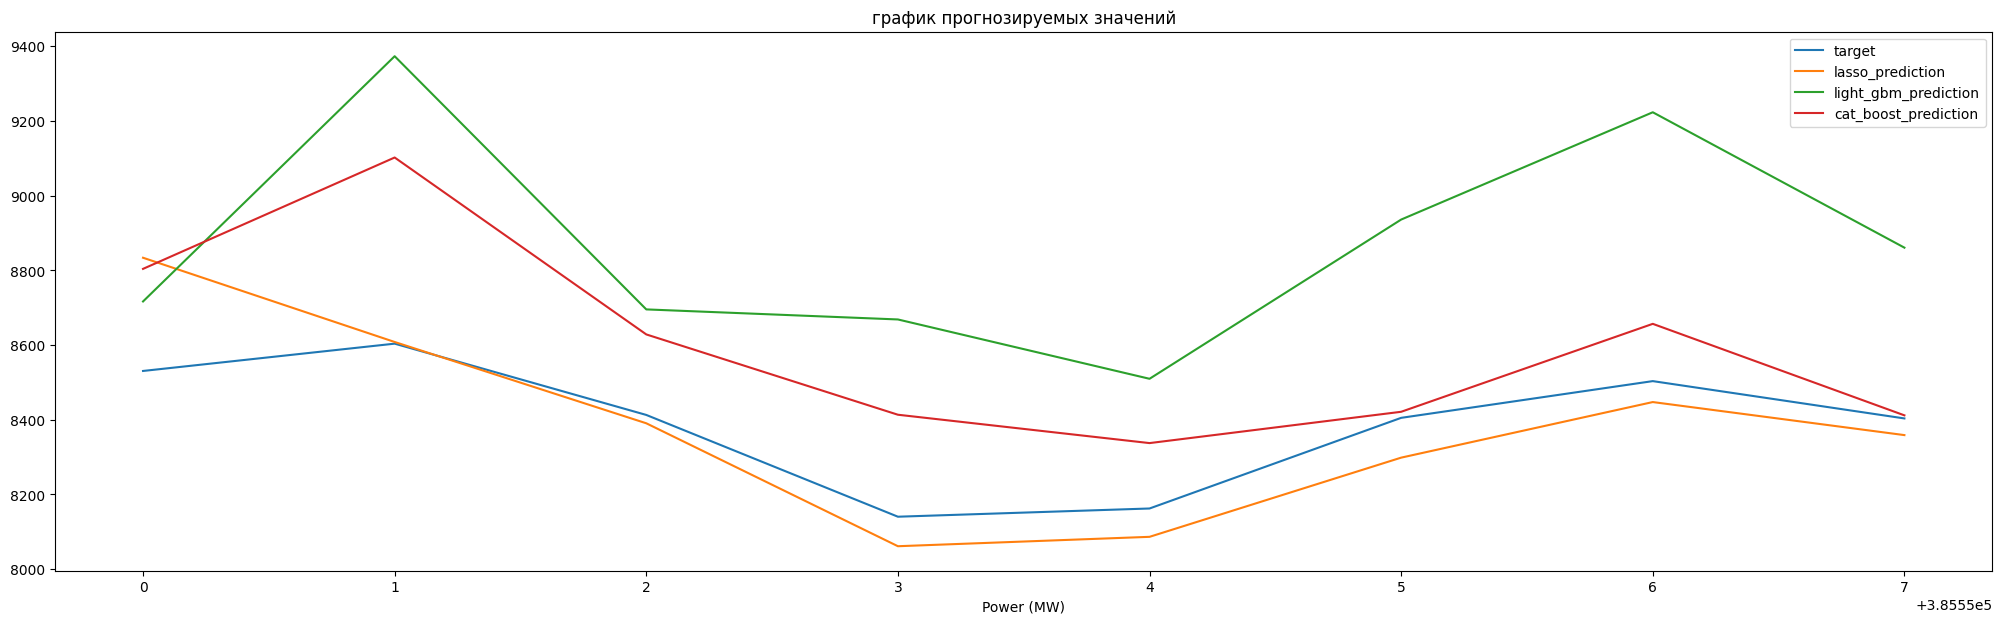

In [557]:
#Построение прогнозируемых результатов на 2 часа
fig,axes = plt.subplots(1,1,figsize=(25,7))
y_test[len(y_test)-target_ahead_timeblocks:len(y_test)].plot(ax=axes)
plt.title('график прогнозируемых значений')
plt.xlabel('Power (MW)')
plt.show()

In [ ]:
############################################################
## А тут и SARIMAX

In [586]:
df_full = wind_data[['datetime', 'power']].copy()
df_full = df_full.set_index('datetime')
df_m = df_full.resample('M').mean()
df_m['power'] = np.log(df_m['power'])
df_m['power'] = df_m['power'].diff()  

In [588]:
    test_size = 12
    
    # Разделили датасет
    train, test = df_m.iloc[:-test_size], df_m.iloc[-test_size:]
    
    print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 120, Test size: 12


In [600]:
model = SARIMAX(train['power'], order=(0, 0, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              power   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -14.254
Date:                            Fri, 02 May 2025   AIC                             36.509
Time:                                    00:02:16   BIC                             47.200
Sample:                                01-31-2011   HQIC                            40.843
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4551      0.113     -4.017      0.000      -0.677      -0.233
ma.L1         -0.9954      0.992     -1.003      0.316      -2.940       0.950
ma.S.L12      -0.7904      0.139     -5.666      0.000      -1.064      -0.517
sigma2         0.0557      0.056      1.002      0.316      -0.053       0.165
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                 4.46
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               0.83   Skew:                             0.48
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [602]:
forecast = results.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean

In [604]:
rmse = np.sqrt(mean_squared_error(test['power'], forecast_values))
print(f"RMSE: {rmse}")

RMSE: 0.22353126970785286


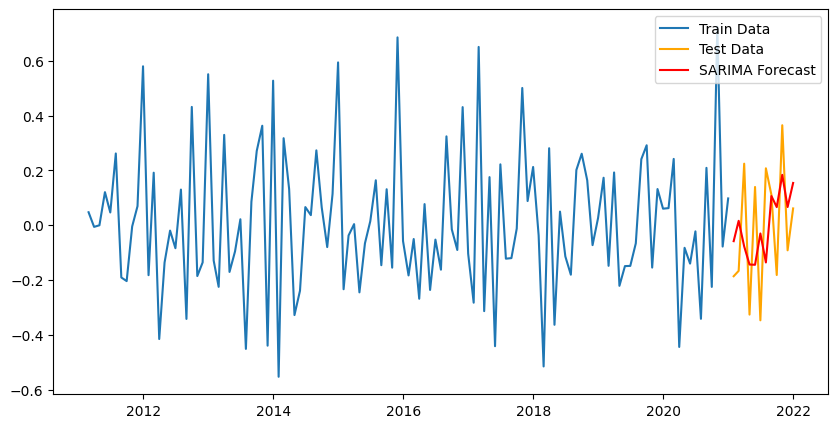

In [606]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['power'], label="Train Data")
plt.plot(test.index, test['power'], label="Test Data", color='orange')
plt.plot(test.index, forecast_values, label="SARIMA Forecast", color='red')
plt.legend()
plt.show()

In [609]:
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []

for train_index, test_index in tscv.split(df_m):
    train, test = df_m.iloc[train_index], df_m.iloc[test_index]

    test_forecast = results.predict(start=len(train), end=len(train)+len(test)-1)

    rmse = np.sqrt(mean_squared_error(test['power'], test_forecast))
    rmse_scores.append(rmse)
    print(f"Fold RMSE: {rmse}")

print(f"Average RMSE: {np.mean(rmse_scores)}")

Fold RMSE: 0.3122938229285608
Fold RMSE: 0.21594394016087815
Fold RMSE: 0.27711669737863437
Fold RMSE: 0.19012736654261347
Fold RMSE: 0.2361668900718092
Average RMSE: 0.24632974341649921


# Исследовательский отчет: Прогнозирование производства электроэнергии ветряными мельницами в Германии

## 1. Описание данных и основные статистики
- **Данные**: 
  - Временной ряд с шагом 15 минут 
  - Период: 01.01.2011 - 30.12.2021 
  - Объем: 385,566 наблюдений
- **Целевая переменная**: `power` (мощность в МВт)
- **Основные статистики**:
  | Метрика | Значение |
  |---------|----------|
  | Средняя мощность | 3183.56 МВт |
  | Максимальная мощность | 16727.5 МВт (21.10.2021) |
  | Минимальная мощность | 0 МВт |
  | Стандартное отклонение | 3045.94 МВт |
- **Выбросы**: 
  - Обнаружено 18,036 выбросов (метод IQR)
  - Верхний порог: 9967.19 МВт

## 2. Визуальный анализ и выводы
### Тренды:
- Рост производства до 2020 года
- Стабилизация после 2020 года
- Пиковые значения в 2019-2021 гг. (расширение ветропарков)

### Сезонность:
- **Суточная**:
  - Максимум: дневные часы
  - Минимум: ночное время
- **Недельная**:
  - Снижение выработки в выходные дни
- **Годовая**:
  - Зимние максимумы (усиление ветров)
  - Летние минимумы

### Аномалии:
- Резкие скачки мощности:
  - Причины: штормовые условия/технические сбои

## 3. Выбор модели
### Модели машинного обучения:
1. **LightGBM**:
   - Преимущества:
     - Учет нелинейных зависимостей
     - Работа с категориальными признаками
   - Результат: RMSE = 362.42 (2-часовой прогноз)

2. **CatBoost**:
   - Преимущества:
     - Автоматическая обработка категорий
     - Устойчивость к переобучению
   - Результат: RMSE = 1137.03

### Временные ряды (SARIMA):
- Параметры: `(0,0,1)(0,1,1,12)`
- Особенности:
  - Учет месячной сезонности
  - Логарифмирование и дифференцирование данных
- Результат: RMSE = 0.22

## 4. Прогноз на год и метрики
### Методология:
- Использована SARIMA для месячных агрегированных данных
- Тестовый период: 2021 год

### Результаты:
| Метрика | Значение |
|---------|----------|
| RMSE на тесте | 0.22 |
| Средний RMSE (CV) | 0.25 |

### Прогноз:
- Сохранение сезонного паттерна:
  - Зимние максимумы
  - Летние минимумы

## Заключение
- **Краткосрочные прогнозы** (2 часа): LightGBM/CatBoost
- **Долгосрочные прогнозы**: SARIMA
